If possible can you please read the extra notebook created, labelled initial investigation, which looked in depth at the meta-data before proceeding into the tasks

### import necessary libraries

In [1]:
import numpy as np
import pandas as pd

# data loading utility (task 1) from util.py
from util import dataLoadingUtil 

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# classification models investigated (including baseline)
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# preprocessing and data paritioning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
X,y,features, labels,encodeObj = dataLoadingUtil()
categories = list(encodeObj.classes_)

## Task 2: Data Analysis and Visualisation

For visualisation purposes and simplicity in analysis, I decided for this section to use the pandas version of X, named "features" and y, named "labels"

In [3]:
features.describe()

,centroid,end,energy,flatness,flux,spectralComplexity,start,zeroCrossingRate,onsetTime,gfcc_0,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
count,8.869000e+03,8.869000e+03,8869.000000,8869.000000,8869.000000,8869.000000,8.869000e+03,8869.000000,8869.000000,8869.000000,...,8869.000000,8869.000000,8869.000000,8869.000000,8869.000000,8869.000000,8869.000000,8869.000000,8869.000000,8869.000000
mean,1.767714e+04,3.432362e+05,623.303827,0.218318,0.159430,22.623746,3.159289e+05,0.050214,7.163920,-48.634024,...,15.661729,4.270428,-2.818704,-1.420728,-4.239731,-6.368248,-5.166636,-6.333034,-3.973364,-4.529521
std,1.134418e+06,8.110796e+05,1069.372268,0.149044,0.123880,25.763693,8.127405e+05,0.069374,18.429490,107.851206,...,31.659629,21.925791,22.329778,16.671187,13.440946,12.808239,13.404507,12.173085,11.992442,11.350033
min,-3.220687e+07,3.072000e+03,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-1138.420044,...,-96.141403,-104.838181,-104.880447,-66.713356,-67.574982,-58.415958,-53.744858,-54.972675,-45.293911,-57.578896
25%,-1.031575e+02,4.461200e+04,33.281361,0.104474,0.060641,5.000000,5.120000e+02,0.013215,0.011610,-113.766624,...,-1.595623,-10.174484,-16.029289,-12.709541,-13.011930,-14.619471,-14.088875,-14.043768,-11.559340,-11.566746
50%,7.438826e+03,9.318400e+04,152.999313,0.188444,0.119674,14.000000,6.604800e+04,0.032242,1.497687,-32.902012,...,19.543804,6.756340,-1.394463,-3.016800,-4.996918,-6.823515,-5.872700,-6.746395,-4.856987,-4.916508
75%,1.848971e+04,2.078720e+05,743.375916,0.305977,0.246350,29.000000,1.863680e+05,0.054785,4.226032,28.015863,...,37.037453,20.705811,14.153173,11.076092,4.859926,2.872082,3.302673,0.876923,1.874651,1.340988
max,9.158153e+07,4.762742e+06,13726.237305,0.812153,0.836587,100.000000,4.754432e+06,0.807732,107.810249,195.483231,...,97.864410,66.647125,57.037239,59.622993,50.302811,51.666412,61.233120,55.248886,70.793694,65.657410


### looking for features with constant values

In [4]:
for feature in features:
    if features[feature].min() == features[feature].max():
        print(feature)

There are no features with constant values, therefore no extra preprocessing needs to be done to remove such features

### looking at the spread based on the mean of the features

In [5]:
print("average across the features' mean", features.mean().mean())

average across the features' mean 14706.356024452316


In [6]:
print("standard deviation across the features' mean", features.mean().std())

standard deviation across the features' mean 67984.8150027002


In [7]:
print("smallest mean across features:", features.mean().min())
print("largest mean across features:", features.mean().max())

smallest mean across features: -875.0051124393096
largest mean across features: 343236.2096064945


Looking at the mean of the 46 features in question, there is a wide spread across the means. The means range from around -875 to around 343,000 in value. In addition, the average and standard deviation of these means are large emphasising the spread. The question this poses is the possibility of pre-processing the data by normalising (ie by standardisation) the features. This would result in each feature in the training set having a mean of 0and variance or standard deviation of 1. This would enable comparison between features to make a lot more comparative sense.

### Correlation between features

In [8]:
def get_redundant_pairs(df):
    '''ie to get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

#  Note: pearson correlation coefficient [-1,1]
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr(method='pearson').abs().unstack() # get a vector of correlation coefficients
    labels_to_drop = get_redundant_pairs(df) # remove diagonals and lower triangular pairs
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False) # sort in descending order
    return au_corr[0:n]

def get_lowest_abs_correlations(df, n=10):
    au_corr = df.corr(method='pearson').abs().unstack() 
    labels_to_drop = get_redundant_pairs(df) 
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True) # sort in ascending order
    return au_corr[0:n]

In [9]:
print("Top 10 absolute Correlations")
print(get_top_abs_correlations(features, 10))

Top 10 absolute Correlations
end     start     0.999845
gfcc_0  mfcc_0    0.914472
gfcc_2  mfcc_2    0.910180
lpc_5   lpc_6     0.904110
gfcc_1  mfcc_1    0.893181
lpc_1   lpc_2     0.876898
lpc_7   lpc_8     0.874218
lpc_9   lpc_10    0.854618
energy  flux      0.826962
lpc_3   lpc_4     0.822381
dtype: float64


The features named "start" and "end" are the most extremely correlated pairs. They are almost perfectly absolute correlated.

In [10]:
print("Lowest 10 absolute Correlations")
print(get_lowest_abs_correlations(features, 10))

Lowest 10 absolute Correlations
centroid  end        0.000014
start     lpc_10     0.000032
gfcc_10   mfcc_6     0.000084
centroid  gfcc_11    0.000154
          gfcc_0     0.000157
          lpc_0      0.000163
end       lpc_10     0.000181
centroid  lpc_6      0.000184
          start      0.000197
lpc_10    mfcc_0     0.000270
dtype: float64


The pair of features with the least correlation are "centroid" and "end"

### Pairwise plot of uncorrelated and correlated features

Plot of centroid feature against the end feature. Uncorrelated pairs

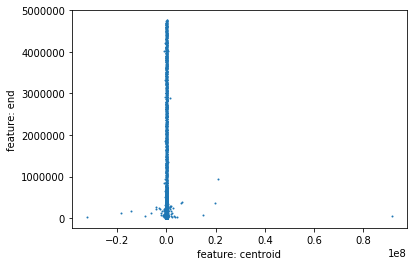

In [11]:
feat_1 = features['centroid']
feat_2 = features['end']


plt.scatter(feat_1, feat_2, s=1)
plt.xlabel('feature: centroid')
plt.ylabel('feature: end')
plt.show()

Plot of start feature against the end feature. Extremely correlated pairs

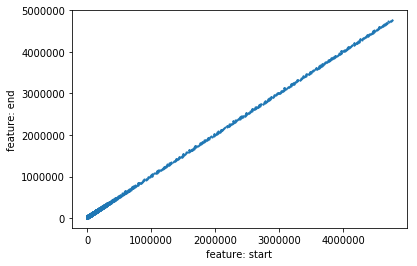

In [12]:
feat_1 = features['start']
feat_2 = features['end']


plt.scatter(feat_1, feat_2, s=1)
plt.xlabel('feature: start')
plt.ylabel('feature: end')
plt.show()

### looking at the (possible) class imbalance

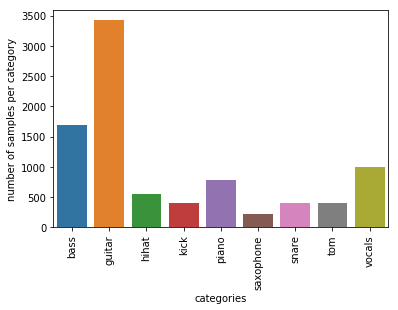

In [13]:
ax = sns.countplot(x=labels)

plot_labels = list(categories)
ax.set_xticklabels(plot_labels)
_, labelling = plt.xticks()
plt.setp(labelling, rotation=90)
plt.xlabel('categories')
plt.ylabel('number of samples per category')
plt.show()

As suggested in the preliminary investigation, here the plot of the number of samples per category prove that there exists class imbalance in the dataset. Here we see that, the most frequent class is the guitar category which is double that of the second more frequent class, bass. The least frequent class is the saxophone class.

## Task 3: Classification

For this task, the use of the numpy arrays named X and y are used. Initially, I partition the data into training, validation and testing splits using the stratified sampling split. The split is 60:20:20 as mentioned in the initial investigation and takes into account the proportion of each category in the dataset.

In [14]:
# split train, validation and test (60,20,20)
# fix the random seed state for reproducibility
X_trainVal, X_test, y_trainVal, y_test = train_test_split(X, y, test_size=0.2, random_state=10031996, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.25, random_state=10031996,stratify=y_trainVal)

In [15]:
# test
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5321, 46), (5321,), (1774, 46), (1774,), (1774, 46), (1774,))

#### import required libraries

In [16]:
# standardising to result in mean 0 and variance of 1 
# on the training set, transform appropriately to validation/test
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

#### Helper function to construct a confusion matrix

In [17]:
def plot_confusion_matrix(cm, title):
    
    classes = categories
    plt.figure(figsize=(6,6))


    sum_cm = np.sum(cm, axis=1)[:,None]

    normalised_cm = cm/sum_cm # normalise confusion matrix
    
    
    """Plots a confusion matrix."""
    sns.heatmap(normalised_cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)

    plt.title(title)
    plt.xlabel('Predictions (model)')
    plt.ylabel('Truth')

### Baseline models

#### Stratified baseline: non-standardised dataset

Validation accuracy of model: 0.21082299887260428


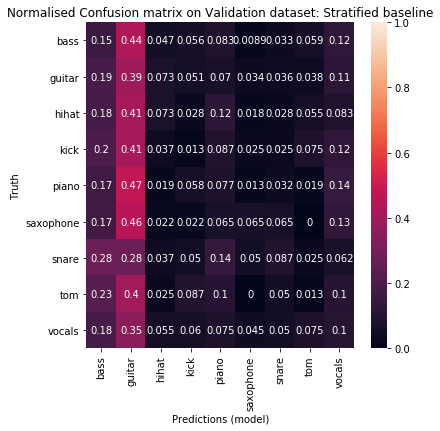

In [18]:
baseline1 = DummyClassifier(strategy='stratified', random_state=1) # predict based on probability
baseline1Build = baseline1.fit(X=X_train,y = y_train)

baseline1Pred = baseline1Build.predict(X=X_val)
print("Validation accuracy of model:", accuracy_score(y_true=y_val, y_pred=baseline1Pred))

conf_matrix = confusion_matrix(y_true=y_val, y_pred=baseline1Pred)
plot_confusion_matrix(cm=conf_matrix, title='Normalised Confusion matrix on Validation dataset: Stratified baseline')

#### Stratified baseline: standardised dataset

Validation accuracy of model: 0.21082299887260428


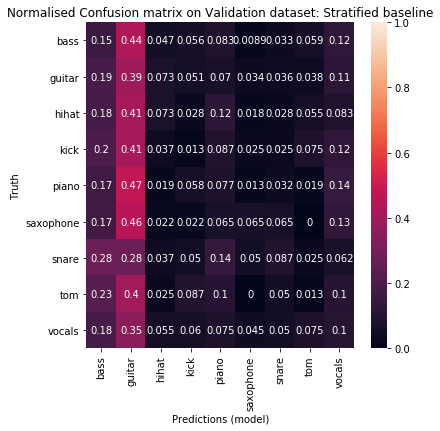

In [19]:
baseline1_std = DummyClassifier(strategy='stratified', random_state=1) # predict based on probability
baseline1Build_std = baseline1_std.fit(X=X_train_std,y = y_train)

baseline1Pred_std = baseline1Build_std.predict(X=X_val_std)
print("Validation accuracy of model:", accuracy_score(y_true=y_val, y_pred=baseline1Pred_std))

conf_matrix = confusion_matrix(y_true=y_val, y_pred=baseline1Pred_std)
plot_confusion_matrix(cm=conf_matrix, title='Normalised Confusion matrix on Validation dataset: Stratified baseline')

#### Most frequent baseline: non-standardised dataset

Validation accuracy of model: 0.38613303269447574


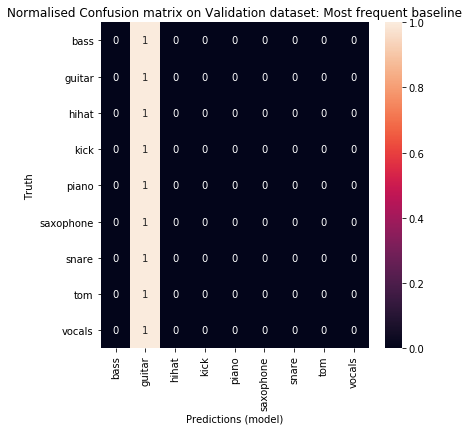

In [20]:
baseline2 = DummyClassifier(strategy='most_frequent', random_state=1) # always predict guitar
baseline2Build = baseline2.fit(X=X_train,y = y_train)

baseline2Pred = baseline2Build.predict(X=X_val)
print("Validation accuracy of model:", accuracy_score(y_true=y_val, y_pred=baseline2Pred))

conf_matrix = confusion_matrix(y_true=y_val, y_pred=baseline2Pred)
plot_confusion_matrix(cm=conf_matrix, title='Normalised Confusion matrix on Validation dataset: Most frequent baseline')



#### Most frequent baseline: standardised dataset

Validation accuracy of model: 0.38613303269447574


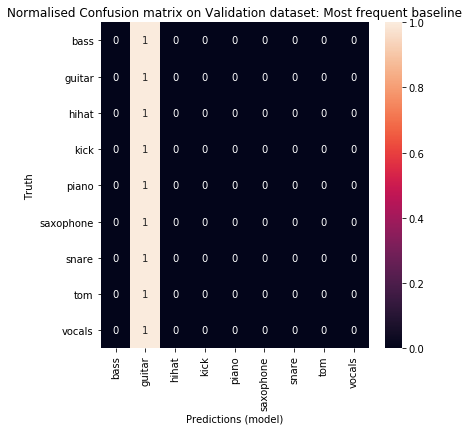

In [21]:
baseline2_std = DummyClassifier(strategy='most_frequent', random_state=1) # always predict guitar
baseline2Build_std = baseline2_std.fit(X=X_train_std,y = y_train)

baseline2Pred_std = baseline2Build_std.predict(X=X_val_std)
print("Validation accuracy of model:", accuracy_score(y_true=y_val, y_pred=baseline2Pred_std))

conf_matrix = confusion_matrix(y_true=y_val, y_pred=baseline2Pred_std)
plot_confusion_matrix(cm=conf_matrix, title='Normalised Confusion matrix on Validation dataset: Most frequent baseline')



#### Comment on baseline models
The majority class classifier (most frequent) is a better baseline than the stratified baseline when focusing on the accuracy. However, the lack of variation in the model's prediction makes it worse when analysing the respective confusion matrices. For now though, the strengths of both baselines will be used to compare against the non-baseline models. This means that the non-baseline models should ideally perform better in terms of accuracy than the majority class classifier and have better predictive variation and performance in the confusion matrix than the stratified baseline classifier. Standardising the dataset does not affect the performance of the baselines in question here.

### Non-baseline models

I decided to focus initially on simpler models, than relatively more complex models such as neural networks which can be harder to apply in practice. The two model types focused here are an instance-based and non-instance based model. The instance based model of choice is the K nearest neighbour classifier. The non-instance based model of choice is the decision tree classifier, a (piece-wise) linear model.

### K Nearest Neigbours classifier:

An approach for finding a good choice of the number of neighbours is to iterate up to the square root of the number of samples. In this case, the training dataset, has 5321 samples with the square root being roughly 73. Therefore, an interation from 1 neighbour to 73 neighbours will be undergone to find the best setting based on the validation accuracy. These are based on the default setting of the sci-kit learn functionality, which for example uses euclidean distance as the distance metric.

#### KNN: non-standardised dataset

Validation accuracy of 20 nearest neighbours model:0.5682074408117249


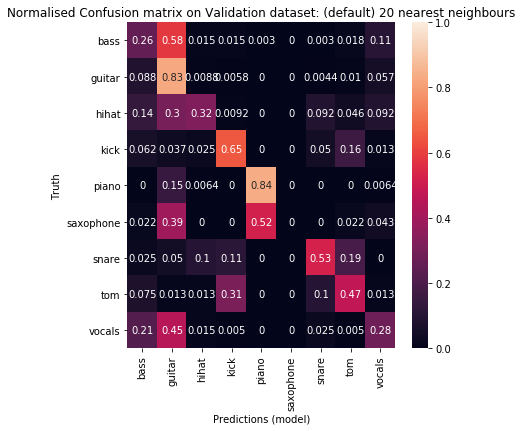

In [22]:
# Instance based learning model: simple 

best_accuracy = 0
best_k = 0

for k in range(1,80):
    knn = KNeighborsClassifier(n_neighbors=k) # default
    knnBuild = knn.fit(X=X_train,y = y_train)

    knnPred = knnBuild.predict(X=X_val)
    score = accuracy_score(y_true=y_val, y_pred=knnPred)
    
    if score > best_accuracy:
        best_accuracy = score
        best_k = k
        
        
    
knn = KNeighborsClassifier(n_neighbors=best_k) # default
knnBuild = knn.fit(X=X_train,y = y_train)

knnPred = knnBuild.predict(X=X_val)
score = accuracy_score(y_true=y_val, y_pred=knnPred)
    
print("Validation accuracy of {} nearest neighbours model:{}".format(best_k, accuracy_score(y_true=y_val, y_pred=knnPred)))

conf_matrix = confusion_matrix(y_true=y_val, y_pred=knnPred)
plot_confusion_matrix(cm=conf_matrix, title='Normalised Confusion matrix on Validation dataset: (default) 20 nearest neighbours')


The 20 nearest neighbours classifer performed best across the different choice of k on the non-standardised dataset. This model has a validation accuracy of around 57%. From the confusion matrix, the model performs really well at predicting guitar and piano, but performs really bad at predicting a sample as belonging to the saxophone category. For this specific category it seemed to confuse it with the piano and guitar. These results appear average, a way to gauge using the confusion matrix, the predictive power of the model is if most of the entires are centred around the diagonal (top-left to bottom-right). Here, the performance is varied, one could say that the model is not confident in its predictions.

#### KNN: standardised dataset

Validation accuracy of 1 nearest neighbours model:0.9549041713641488


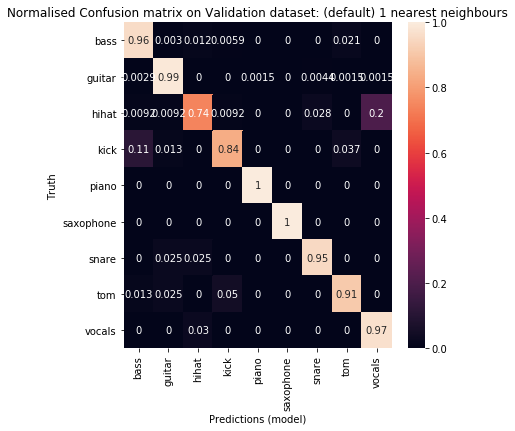

In [23]:
best_accuracy = 0
best_k = 0

for k in range(1,80):
    knn_std = KNeighborsClassifier(n_neighbors=k) # default
    knnBuild_std = knn_std.fit(X=X_train_std,y = y_train)

    knnPred_std = knnBuild_std.predict(X=X_val_std)
    score = accuracy_score(y_true=y_val, y_pred=knnPred_std)
    
    if score > best_accuracy:
        best_accuracy = score
        best_k = k
        
        
    
knn_std = KNeighborsClassifier(n_neighbors=best_k) # default
knnBuild_std = knn_std.fit(X=X_train_std,y = y_train)

knnPred_std = knnBuild_std.predict(X=X_val_std)
score = accuracy_score(y_true=y_val, y_pred=knnPred_std)
    
print("Validation accuracy of {} nearest neighbours model:{}".format(best_k, accuracy_score(y_true=y_val, y_pred=knnPred_std)))

conf_matrix = confusion_matrix(y_true=y_val, y_pred=knnPred_std)
plot_confusion_matrix(cm=conf_matrix, title='Normalised Confusion matrix on Validation dataset: (default) 1 nearest neighbours')


In comparison, to the non-standardised dataset K-NN and baselines, the 1 nearest neighbour classifier on the standardised dataset performs extremely well. It is perfect at predicting a piano and saxophone. However, it did have a slight problem in distinguishing between hi-hat and vocals, and to a less extent between the kick-drums and bass. This is a really promising performance and it especially emphasises the impact of normalising the data  features.

### Decision Tree Classifier

This is a non-instance based machine learning model. It is also a simple model as it is implicity linear, specifically piece-wise linear.

#### Decision Tree: non-standardised dataset

Validation accuracy of model: 0.911499436302142


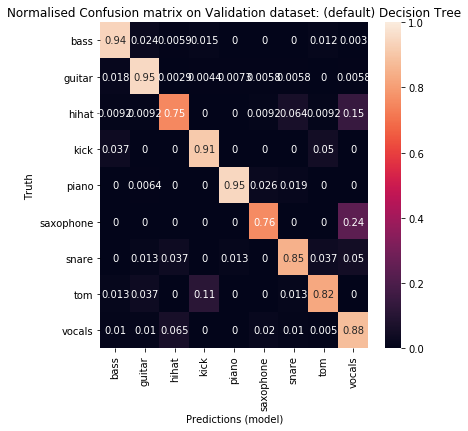

In [24]:
dt = DecisionTreeClassifier(random_state=1) # default
dtBuild = dt.fit(X=X_train,y = y_train)

dtPred = dtBuild.predict(X=X_val)
accuracy_score(y_true=y_val, y_pred=dtPred)

print("Validation accuracy of model:", accuracy_score(y_true=y_val, y_pred=dtPred))

conf_matrix = confusion_matrix(y_true=y_val, y_pred=dtPred)
plot_confusion_matrix(cm=conf_matrix, title='Normalised Confusion matrix on Validation dataset: (default) Decision Tree')

#### Decision Tree: standardised dataset

Validation accuracy of model: 0.911499436302142


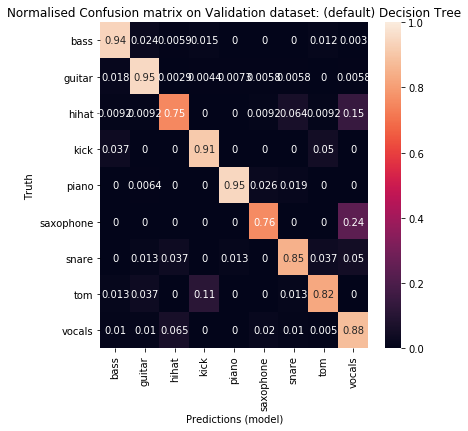

In [25]:
dt_std = DecisionTreeClassifier(random_state=1) # default
dtBuild_std = dt_std.fit(X=X_train_std,y = y_train)

dtPred_std = dtBuild_std.predict(X=X_val_std)
accuracy_score(y_true=y_val, y_pred=dtPred_std)

print("Validation accuracy of model:", accuracy_score(y_true=y_val, y_pred=dtPred_std))

conf_matrix = confusion_matrix(y_true=y_val, y_pred=dtPred_std)
plot_confusion_matrix(cm=conf_matrix, title='Normalised Confusion matrix on Validation dataset: (default) Decision Tree')

The (default) decision tree model is really good at predicting the category of bass, guitar, kick and piano. However, it finds it difficult to distinguish between; saxophone and vocals, hihat and vocals, and tom and kick. I believe that if one removed the vocals as a category, this model would perform extremely well, however, that would change the problem description. However, this model generally performs really well based on the validation accuracy and the confusion matrix. In addition, as expected, the standardisation of the dataset does not affect the decision tree performance given the decision tree splits on a specific feature and standardising would not affect the resulting split only the nominal value.

## Final chosen model: 1 Nearest Neighbour, standardised data

The 1 nearest neighbour model on the standardised dataset had the  highest accuracy on the validation dataset and the best performance from the confusion matrix, in comparison to the other model choices made. In addition, as this model just finds the nearest, it is in evaluation a lot quicker than the decision tree model. The issue is that all the training data has to be stored and used beforehand, nonetheless, the benefits here definitely outweigh it's negative. It could prove problematic in practice, so maybe more efficient representations may be needed.

Here, I report the generalisation accuracy, also known as testing accuracy, based on held-out test dataset. This or a slight variant reports an unbiases approximation of the generalisation performance of the model for this problem on unseen data.

Generalisation performance of chosen model, 1-NN, standardised data: 0.9487034949267192


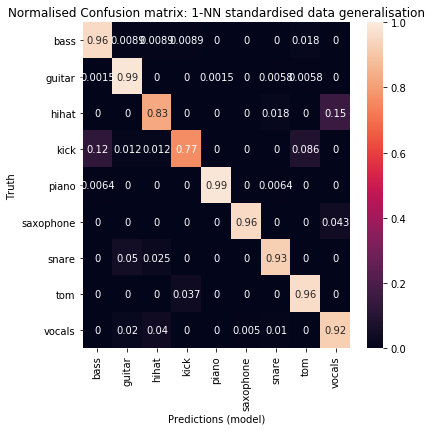

In [26]:
knnTest_std = knnBuild_std.predict(X=X_test_std)
print("Generalisation performance of chosen model, 1-NN, standardised data:", accuracy_score(y_true=y_test, y_pred=knnTest_std))

conf_matrix = confusion_matrix(y_true=y_test, y_pred=knnTest_std)
plot_confusion_matrix(cm=conf_matrix, title='Normalised Confusion matrix: 1-NN standardised data generalisation')